### 문제 7-1 : LangGraph ReAct Agent 실습 연습문제 (Vector DB + Tool 연동)

In [87]:
import os
from dotenv import load_dotenv

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])

gs


In [88]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import tools_condition
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from typing import List
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [89]:
embeddings_model = OllamaEmbeddings(model="bge-m3:latest")

# cafe db 벡터 저장소 로드
cafe_db = FAISS.load_local(
    "../db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# Tool 정의 
@tool
def search_menu(query: str) -> List[str]:
    """카페 메뉴에서 정보를 검색합니다."""
    docs = cafe_db.similarity_search(query, k=6)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 메뉴 정보를 찾을 수 없습니다."

In [90]:
class AgentState(MessagesState):
    pass

llm = ChatOpenAI(
    api_key=OPENAI_API_KEY,
    base_url="https://api.groq.com/openai/v1",
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0.3
)

tools = [search_menu]
llm_with_tools = llm.bind_tools(tools = tools)

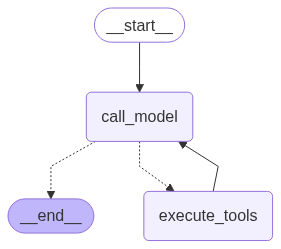

In [91]:
def call_model(state):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": messages + [response]}

def should_continue(state: AgentState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "execute_tools"
    return END

builder = StateGraph(AgentState)
builder.add_node("call_model", call_model)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model", 
    should_continue,
    {
        "execute_tools": "execute_tools",
        END: END
    }
)
builder.add_edge("execute_tools", "call_model")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [92]:
memory = MemorySaver()
config = {"configurable": {"thread_id": "1"}}


In [93]:
messages = [HumanMessage(content="아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.")]
response = graph.invoke({"messages": messages}, config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.
================================== Ai Message ==================================
Tool Calls:
  search_menu (sy3w0p5gb)
 Call ID: sy3w0p5gb
  Args:
    query: 아메리픨벐 아이스 아메리픨벐 차이점 가격
================================= Tool Message =================================
Name: search_menu

<Document source="../data/cafe_menu_data.txt"/>
2. 카페라떼
   • 가격: ₩5,500
   • 주요 원료: 에스프레소, 스팀 밀크
   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 밀크 커피입니다. 크리미한 질감과 부드러운 맛이 특징이며, 다양한 시럽과 토핑 추가가 가능합니다. 라떼 아트로 시각적 즐거움도 제공합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
7. 프라푸치노
   • 가격: ₩7,000
   • 주요 원료: 에스프레소, 우유, 얼음, 휘핑크림
   • 설명: 에스프레소와 우유, 얼음을 블렌더에 갈아 만든 시원한 음료입니다. 부드럽고 크리미한 질감이 특징이며, 휘핑크림을 올려 달콤함을 더했습니다. 여름철 인기 메뉴입니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
6. 콜드브루
   • 가격: ₩5,000
   • 주요 원료: 콜드브루 원액, 차가운 물
   • 설명: 찬물에 12-24시간 우려낸 콜드브루 원액을 사용한 시원한 커피

In [94]:
messages = [HumanMessage(content="라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?")]
response = graph.invoke({"messages": messages}, config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (r5xv0w63y)
 Call ID: r5xv0w63y
  Args:
    query: 일본라떼� 벤이오는 또는 벤이오는 라떼�
================================= Tool Message =================================
Name: search_menu

<Document source="../data/cafe_menu_data.txt"/>
2. 카페라떼
   • 가격: ₩5,500
   • 주요 원료: 에스프레소, 스팀 밀크
   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 밀크 커피입니다. 크리미한 질감과 부드러운 맛이 특징이며, 다양한 시럽과 토핑 추가가 가능합니다. 라떼 아트로 시각적 즐거움도 제공합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
6. 콜드브루
   • 가격: ₩5,000
   • 주요 원료: 콜드브루 원액, 차가운 물
   • 설명: 찬물에 12-24시간 우려낸 콜드브루 원액을 사용한 시원한 커피입니다. 부드럽고 달콤한 맛이 특징이며, 산미가 적어 누구나 부담 없이 즐길 수 있습니다. 얼음과 함께 시원하게 제공됩니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
7. 프라푸치노
   • 가격: ₩7,000
   • 주요 원료: 에스프레소, 우유, 얼음, 휘핑크림
   • 설명: 에스프레소와 우유, 얼음을 블렌더에 갈아

In [95]:
messages = [HumanMessage(content="디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요.")]
response = graph.invoke({"messages": messages}, config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요.
================================== Ai Message ==================================
Tool Calls:
  search_menu (5t36fn8vh)
 Call ID: 5t36fn8vh
  Args:
    query: 안녕 팀리미수
================================= Tool Message =================================
Name: search_menu

<Document source="../data/cafe_menu_data.txt"/>
10. 티라미수
    • 가격: ₩7,500
    • 주요 원료: 마스카포네 치즈, 에스프레소, 레이디핑거, 코코아 파우더
    • 설명: 이탈리아 전통 디저트로 마스카포네 치즈와 에스프레소에 적신 레이디핑거를 층층이 쌓아 만들었습니다. 부드럽고 달콤한 맛이 특징이며, 코코아 파우더로 마무리하여 깊은 풍미를 자랑합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
2. 카페라떼
   • 가격: ₩5,500
   • 주요 원료: 에스프레소, 스팀 밀크
   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 밀크 커피입니다. 크리미한 질감과 부드러운 맛이 특징이며, 다양한 시럽과 토핑 추가가 가능합니다. 라떼 아트로 시각적 즐거움도 제공합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
6. 콜드브루
   • 가격: ₩5,000
   • 주요 원료: 콜드브루 원액, 차가운 물
   • 설명: 찬물에 12-24시간 우려낸 콜드브루 원액을 사용